In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from scipy.optimize import minimize

import electricPotentialEnergy as pe

### Initialize the system

Initial Energy: 151.30061482359991


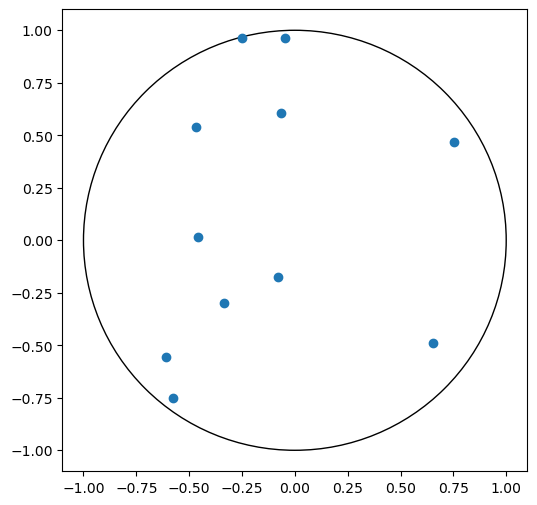

In [8]:
system = pe.Coulomb(11)

fig, ax = pe.plotState(system.state)
print(f"Initial Energy: {system.stateEnergy()}")

### Run Simulated Annealing

/Users/Kattelijn/Desktop/stochSim3/electricPotentialEnergy.py:114: RuntimeWarning: overflow encountered in scalar divide
  acceptance_prob = np.exp(-(system.newEnergy - system.currentEnergy) / temp)
/Users/Kattelijn/Desktop/stochSim3/electricPotentialEnergy.py:114: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = np.exp(-(system.newEnergy - system.currentEnergy) / temp)


[151.30061482 139.74867762 131.47088607 ... 125.92297855 141.77936778
 134.61479405]
Final Energy: 102.32225039686215


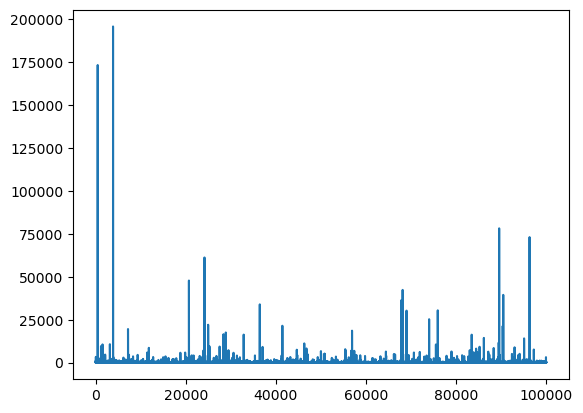

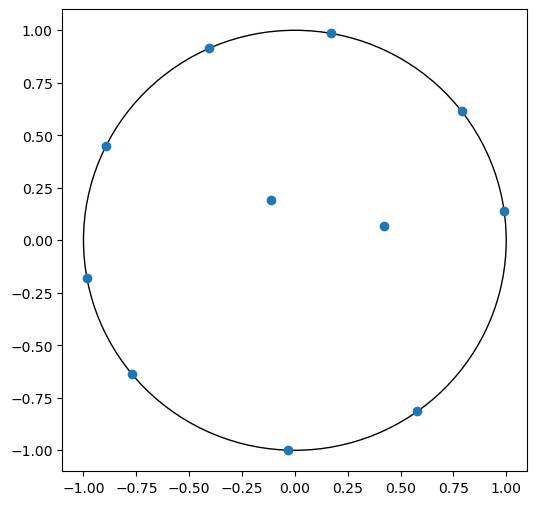

In [9]:
max_iters = 100000
initial_temp = 10
cooling_rate = 0.0001
max_step = 2

filename = "test"

scheme = pe.arithmeticGeometric(initial_temp, cooling_rate, 0)
optimized_system, energy = pe.simulatedAnnealing(system, 10, max_iters, scheme, max_step, save_path=filename)

plt.plot(energy)
print(energy)

fig, ax = pe.plotState(optimized_system.state)
print(f"Final Energy: {optimized_system.stateEnergy()}")
plt.show()

In [ ]:
optimum = minimize(pe.optimize,x0=[0.25, 0.25], method='Powell', bounds=[[0.1,1], [0.1,1]], options={'disp':True})

### Load simulation results

In [5]:
saved_states = np.load(f"{filename}_states.npy")
saved_energies = np.load(f"{filename}_energies.pny")

### Create animation using simulation results

In [ ]:
def update(frame):
    """Update function for the animation."""
    pe.plotState(saved_states[frame], animation=True, ax=ax)
    ax.set_title(f"Frame {frame+1}")

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(fig, update, frames=len(saved_states), interval=200)

ani.save(f"{filename}.mp4", fps=50)